In [ ]:
# Basic libraries
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

# Image processing
from PIL import Image
import cv2

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define training directory path
train_path = "/content/drive/MyDrive/Dataset/Train"

# Count and display number of images in each class
class_counts = {}
for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    class_counts[folder] = len(os.listdir(folder_path))

# Display count
print("Class-wise image count BEFORE augmentation:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

Class-wise image count BEFORE augmentation:
squamous cell carcinoma: 181
vascular lesion: 139
nevus: 357
pigmented benign keratosis: 462
actinic keratosis: 114
dermatofibroma: 95
melanoma: 438
seborrheic keratosis: 77
basal cell carcinoma: 376


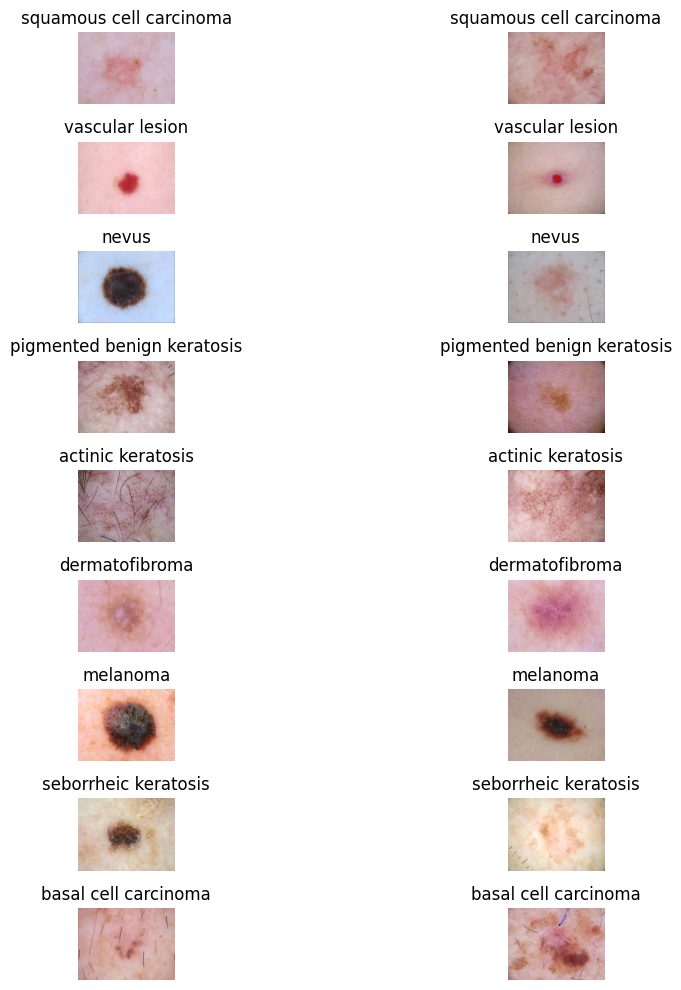

In [ ]:
# Display 2 images from each class
plt.figure(figsize=(12, 10))
i = 1
for cls in os.listdir(train_path):
    path = os.path.join(train_path, cls)
    for img_name in os.listdir(path)[:2]:
        img_path = os.path.join(path, img_name)
        img = Image.open(img_path)
        plt.subplot(len(class_counts), 2, i)
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")
        i += 1
plt.tight_layout()
plt.show()

In [ ]:
# Augmentation and save folder setup
aug_path = "/content/drive/MyDrive/Dataset/Augmented_Train"
os.makedirs(aug_path, exist_ok=True)

# Image size
img_size = (224, 224)

# Data augmentation configuration
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Perform augmentation
for cls in tqdm(os.listdir(train_path), desc="Augmenting"):
    src_dir = os.path.join(train_path, cls)
    dest_dir = os.path.join(aug_path, cls)
    os.makedirs(dest_dir, exist_ok=True)

    existing_images = os.listdir(src_dir)
    current_count = len(existing_images)

    # Copy existing images
    for img_name in existing_images:
        shutil.copy(os.path.join(src_dir, img_name), os.path.join(dest_dir, img_name))

    # Start augmenting until 600 images
    while len(os.listdir(dest_dir)) < 600:
        img_name = random.choice(existing_images)
        img_path = os.path.join(src_dir, img_name)
        img = load_img(img_path, target_size=img_size)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        for batch in datagen.flow(x, batch_size=1, save_to_dir=dest_dir, save_format='jpg'):
            break  # generate one image

print("Augmentation Complete!")

Augmenting: 100%|██████████| 9/9 [05:03<00:00, 33.75s/it]

Augmentation Complete!


In [ ]:
# Confirm image count after augmentation
print("Class-wise image count AFTER augmentation:")
for folder in os.listdir(aug_path):
    folder_path = os.path.join(aug_path, folder)
    print(f"{folder}: {len(os.listdir(folder_path))}")

Class-wise image count AFTER augmentation:
squamous cell carcinoma: 600
vascular lesion: 600
nevus: 600
pigmented benign keratosis: 600
actinic keratosis: 600
dermatofibroma: 600
melanoma: 600
seborrheic keratosis: 600
basal cell carcinoma: 600


In [ ]:
# Create train-validation split from augmented data
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.1  # 10% validation
)

train_generator = train_datagen.flow_from_directory(
    aug_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    aug_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Save label names
class_labels = train_generator.class_indices
print("Label mapping:", class_labels)

Found 4860 images belonging to 9 classes.
Found 540 images belonging to 9 classes.
Label mapping: {'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4, 'pigmented benign keratosis': 5, 'seborrheic keratosis': 6, 'squamous cell carcinoma': 7, 'vascular lesion': 8}


In [ ]:
# Load VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(class_labels), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,3

 Total params: 14,880,073 (56.76 MB)

 Trainable params: 165,385 (646.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 73s 392ms/step - accuracy: 0.1809 - loss: 3.1310 - val_accuracy: 0.4241 - val_loss: 1.7836 - learning_rate: 1.0000e-04
Epoch 2/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 47s 307ms/step - accuracy: 0.4772 - loss: 1.5227 - val_accuracy: 0.4870 - val_loss: 1.5828 - learning_rate: 1.0000e-04
Epoch 3/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 49s 319ms/step - accuracy: 0.5638 - loss: 1.2509 - val_accuracy: 0.5185 - val_loss: 1.4614 - learning_rate: 1.0000e-04
Epoch 4/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 46s 305ms/step - accuracy: 0.6180 - loss: 1.1163 - val_accuracy: 0.5315 - val_loss: 1.4120 - learning_rate: 1.0000e-04
Epoch 5/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 49s 320ms/step - accuracy: 0.6712 - loss: 0.9882 - val_accuracy: 0.5444 - val_loss: 1.3584 - learning_rate: 1.0000e-04
Epoch 6/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 47s 310ms/step - accuracy: 0.6925 - loss: 0.9137 - val_accuracy: 0.5593 - val_loss: 1.2968 - learning_rate: 1.0000e-04
Epoch 7/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 48s 31

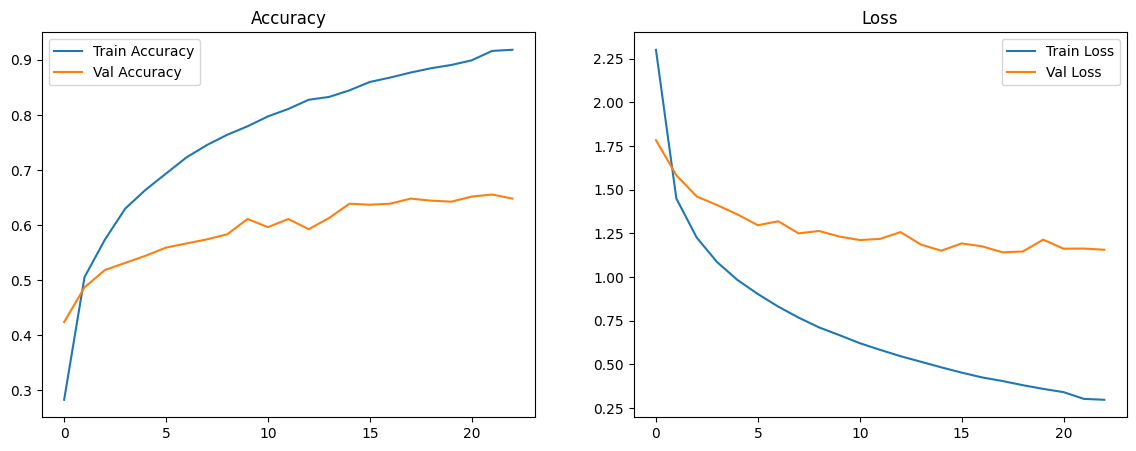

In [ ]:
# Plot training vs validation accuracy/loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()

In [ ]:
# Save model
model.save('/content/drive/MyDrive/Dataset/skin_model_vgg16.h5')
print("Model saved successfully.")

Model saved successfully.


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step


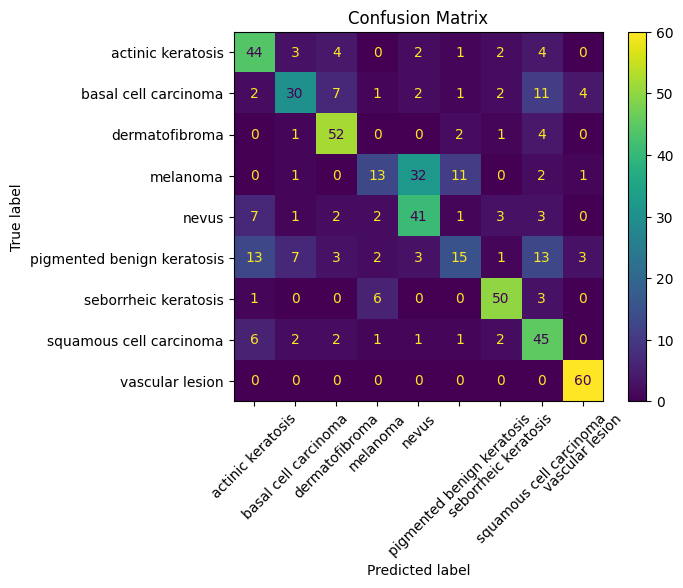

                            precision    recall  f1-score   support

         actinic keratosis       0.60      0.73      0.66        60
      basal cell carcinoma       0.67      0.50      0.57        60
            dermatofibroma       0.74      0.87      0.80        60
                  melanoma       0.52      0.22      0.31        60
                     nevus       0.51      0.68      0.58        60
pigmented benign keratosis       0.47      0.25      0.33        60
      seborrheic keratosis       0.82      0.83      0.83        60
   squamous cell carcinoma       0.53      0.75      0.62        60
           vascular lesion       0.88      1.00      0.94        60

                  accuracy                           0.65       540
                 macro avg       0.64      0.65      0.63       540
              weighted avg       0.64      0.65      0.63       540



In [ ]:
# Predictions on validation set
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys())
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


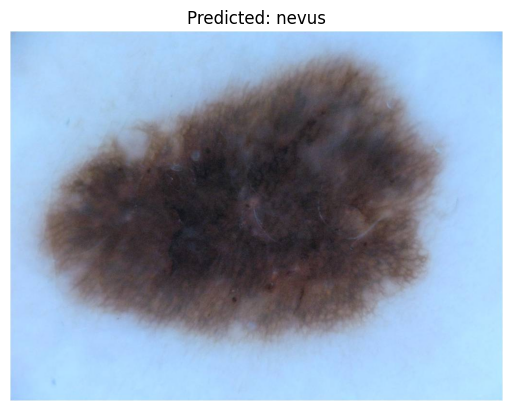

In [ ]:
def predict_image(img_path, model, class_labels):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = preprocess_input(np.expand_dims(img_array, axis=0))

    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]

    plt.imshow(load_img(img_path))
    plt.title(f"Predicted: {predicted_class}")
    plt.axis("off")
    plt.show()

# Example usage
predict_image('/content/drive/MyDrive/Dataset/Test/nevus/nevus (1).jpg', model, class_labels)

In [ ]:
# Load VGG16 without top
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [ ]:

# Load the base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 🔓 Unfreeze block5 and block4 for deeper fine-tuning
for layer in base_model.layers:
    if "block5" in layer.name or "block4" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

# Create new model on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(9, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Dataset/best_model.h5", save_best_only=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.1226 - loss: 2.9386

152/152 ━━━━━━━━━━━━━━━━━━━━ 76s 408ms/step - accuracy: 0.1226 - loss: 2.9352 - val_accuracy: 0.1741 - val_loss: 2.1605
Epoch 2/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.1629 - loss: 2.1475

152/152 ━━━━━━━━━━━━━━━━━━━━ 55s 359ms/step - accuracy: 0.1632 - loss: 2.1472 - val_accuracy: 0.3648 - val_loss: 1.8715
Epoch 3/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.3035 - loss: 1.8911

152/152 ━━━━━━━━━━━━━━━━━━━━ 80s 348ms/step - accuracy: 0.3036 - loss: 1.8908 - val_accuracy: 0.4315 - val_loss: 1.6542
Epoch 4/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.3871 - loss: 1.6542

152/152 ━━━━━━━━━━━━━━━━━━━━ 56s 367ms/step - accuracy: 0.3872 - loss: 1.6538 - val_accuracy: 0.4870 - val_loss: 1.5203
Epoch 5/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.4569 - loss: 1.4593

152/152 ━━━━━━━━━━━━━━━━━━━━ 58s 376ms/step - accuracy: 0.4570 - loss: 1.4591 - val_accuracy: 0.5093 - val_loss: 1.4871
Epoch 6/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.5311 - loss: 1.2892

152/152 ━━━━━━━━━━━━━━━━━━━━ 56s 364ms/step - accuracy: 0.5312 - loss: 1.2889 - val_accuracy: 0.5537 - val_loss: 1.3343
Epoch 7/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.5645 - loss: 1.1929

152/152 ━━━━━━━━━━━━━━━━━━━━ 77s 336ms/step - accuracy: 0.5647 - loss: 1.1925 - val_accuracy: 0.6259 - val_loss: 1.1965
Epoch 8/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.6470 - loss: 1.0105

152/152 ━━━━━━━━━━━━━━━━━━━━ 84s 348ms/step - accuracy: 0.6469 - loss: 1.0105 - val_accuracy: 0.6426 - val_loss: 1.1498
Epoch 9/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.6765 - loss: 0.9346

152/152 ━━━━━━━━━━━━━━━━━━━━ 81s 342ms/step - accuracy: 0.6765 - loss: 0.9346 - val_accuracy: 0.6685 - val_loss: 1.0711
Epoch 10/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.7144 - loss: 0.8206

152/152 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.7144 - loss: 0.8206 - val_accuracy: 0.7056 - val_loss: 1.0473
Epoch 11/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.7446 - loss: 0.7410

152/152 ━━━━━━━━━━━━━━━━━━━━ 60s 392ms/step - accuracy: 0.7446 - loss: 0.7409 - val_accuracy: 0.7222 - val_loss: 0.8964
Epoch 12/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 56s 365ms/step - accuracy: 0.7607 - loss: 0.6920 - val_accuracy: 0.7130 - val_loss: 1.0360
Epoch 13/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 49s 325ms/step - accuracy: 0.7805 - loss: 0.6325 - val_accuracy: 0.7167 - val_loss: 0.9972
Epoch 14/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 50s 325ms/step - accuracy: 0.8182 - loss: 0.5395 - val_accuracy: 0.7315 - val_loss: 1.0566
Epoch 15/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.8233 - loss: 0.5137

152/152 ━━━━━━━━━━━━━━━━━━━━ 51s 335ms/step - accuracy: 0.8233 - loss: 0.5136 - val_accuracy: 0.7741 - val_loss: 0.8555
Epoch 16/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.8539 - loss: 0.4316

152/152 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.8539 - loss: 0.4317 - val_accuracy: 0.7630 - val_loss: 0.8425
Epoch 17/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 56s 362ms/step - accuracy: 0.8488 - loss: 0.4208 - val_accuracy: 0.7667 - val_loss: 0.9979
Epoch 18/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 78s 339ms/step - accuracy: 0.8732 - loss: 0.3584 - val_accuracy: 0.7926 - val_loss: 0.9340
Epoch 19/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 81s 334ms/step - accuracy: 0.8840 - loss: 0.3382 - val_accuracy: 0.7889 - val_loss: 0.9831
Epoch 20/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.8836 - loss: 0.3272

152/152 ━━━━━━━━━━━━━━━━━━━━ 54s 355ms/step - accuracy: 0.8837 - loss: 0.3272 - val_accuracy: 0.8000 - val_loss: 0.7743
Epoch 21/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 56s 364ms/step - accuracy: 0.9064 - loss: 0.2651 - val_accuracy: 0.7833 - val_loss: 1.1699
Epoch 22/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 49s 325ms/step - accuracy: 0.9128 - loss: 0.2491 - val_accuracy: 0.8093 - val_loss: 0.7977
Epoch 23/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 85s 343ms/step - accuracy: 0.9124 - loss: 0.2506 - val_accuracy: 0.8056 - val_loss: 1.0674
Epoch 24/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 51s 335ms/step - accuracy: 0.9223 - loss: 0.2246 - val_accuracy: 0.8222 - val_loss: 0.9424
Epoch 25/25
152/152 ━━━━━━━━━━━━━━━━━━━━ 50s 326ms/step - accuracy: 0.9300 - loss: 0.1891 - val_accuracy: 0.8111 - val_loss: 0.9502


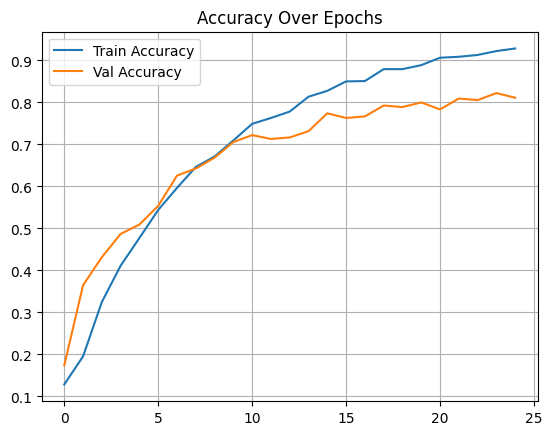

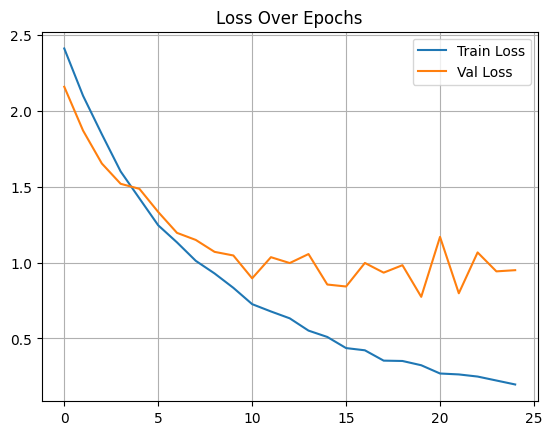

In [ ]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
labels = list(train_generator.class_indices.keys())

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step


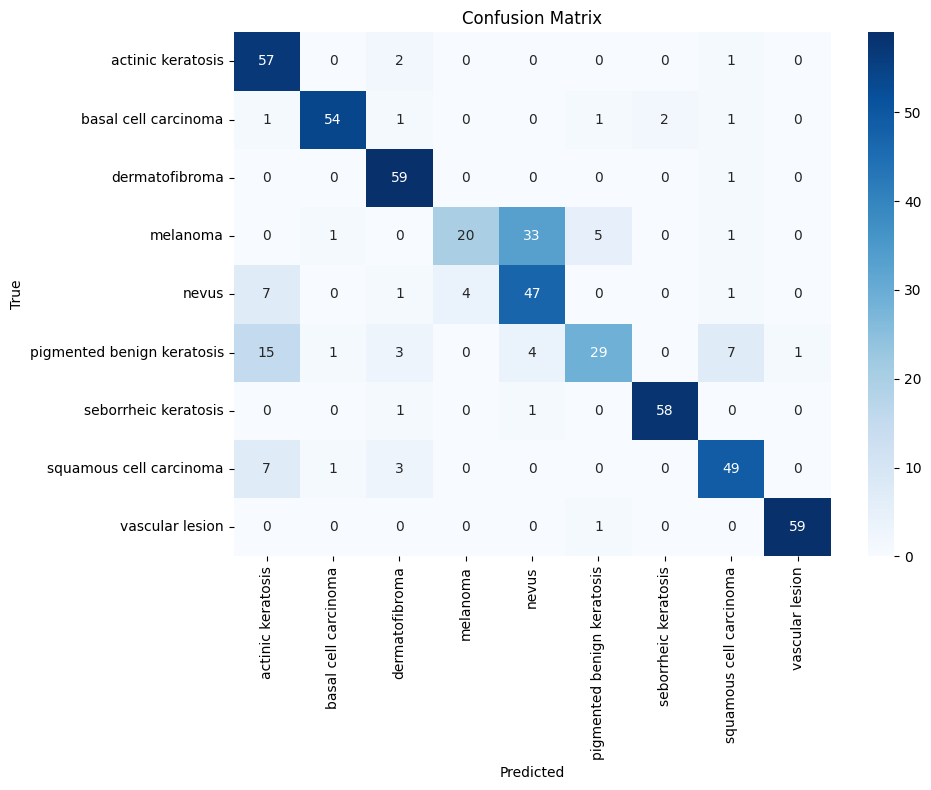

Classification Report:

                            precision    recall  f1-score   support

         actinic keratosis       0.66      0.95      0.78        60
      basal cell carcinoma       0.95      0.90      0.92        60
            dermatofibroma       0.84      0.98      0.91        60
                  melanoma       0.83      0.33      0.48        60
                     nevus       0.55      0.78      0.65        60
pigmented benign keratosis       0.81      0.48      0.60        60
      seborrheic keratosis       0.97      0.97      0.97        60
   squamous cell carcinoma       0.80      0.82      0.81        60
           vascular lesion       0.98      0.98      0.98        60

                  accuracy                           0.80       540
                 macro avg       0.82      0.80      0.79       540
              weighted avg       0.82      0.80      0.79       540



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 🧠 Get true and predicted labels
val_preds = model.predict(val_generator)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_generator.classes

# 🧮 Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 🔥 Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# 🗣️ Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))

Testing Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step


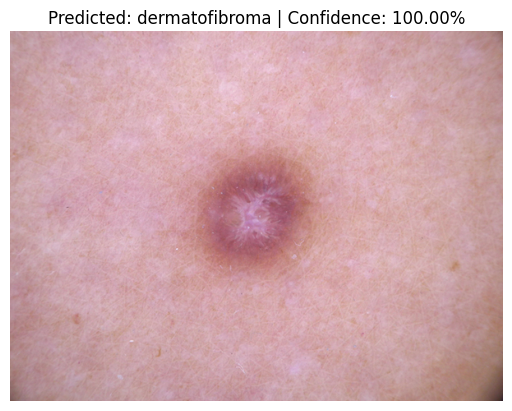

🔍 Raw prediction vector: [[7.4537184e-07 5.9140798e-06 9.9996758e-01 3.7809198e-08 8.8813408e-07
  1.8868019e-05 2.3495257e-08 6.0670698e-07 5.5093174e-06]]
🧠 Predicted Class Index: 2
🏷️ Predicted Class Name: dermatofibroma
📊 Confidence: 100.00%


In [ ]:
# 📚 Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

# 🧠 Load the trained model (fine-tuned and saved earlier)
model_path = '/content/drive/MyDrive/Dataset/best_model.h5'
model = load_model(model_path)

# 🔖 Define the class labels (must be in the same order as during training)
class_labels = [
    'actinic keratosis',
    'basal cell carcinoma',
    'dermatofibroma',
    'melanoma',
    'nevus',
    'pigmented benign keratosis',
    'seborrheic keratosis',
    'squamous cell carcinoma',
    'vascular lesion'
]

# 🔍 Define prediction function
def predict_image(img_path, model, class_labels):
    # Load and preprocess image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = preprocess_input(np.expand_dims(img_array, axis=0))

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]

    # Display the image with prediction
    plt.imshow(load_img(img_path))
    plt.title(f"Predicted: {predicted_class} | Confidence: {np.max(prediction) * 100:.2f}%")
    plt.axis("off")
    plt.show()

    # Print detailed result
    print("🔍 Raw prediction vector:", prediction)
    print("🧠 Predicted Class Index:", np.argmax(prediction))
    print("🏷️ Predicted Class Name:", predicted_class)
    print(f"📊 Confidence: {np.max(prediction) * 100:.2f}%")

# 🧪 Example usage
predict_image(
    '/content/drive/MyDrive/Dataset/Test/dermatofibroma/dermatofibroma (11).jpg',
    model,
    class_labels
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


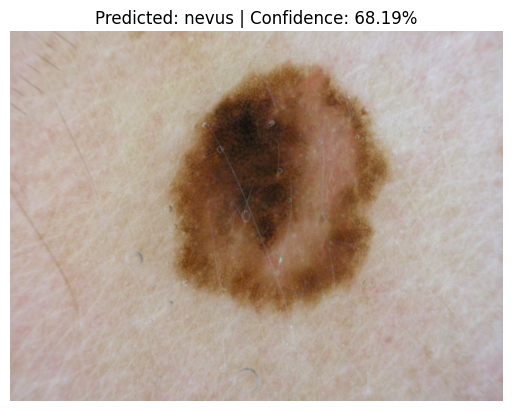

🔍 Raw prediction vector: [[2.9371178e-04 9.7389001e-04 2.4626838e-04 3.0560759e-01 6.8188387e-01
  1.4653824e-03 7.5841942e-03 3.5178068e-04 1.5932211e-03]]
🧠 Predicted Class Index: 4
🏷️ Predicted Class Name: nevus
📊 Confidence: 68.19%


In [ ]:
# 📚 Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

# 🧠 Load the trained model (fine-tuned and saved earlier)
model_path = '/content/drive/MyDrive/Dataset/skin_model_vgg16.h5'
model = load_model(model_path)

# 🔖 Define the class labels (must be in the same order as during training)
class_labels = [
    'actinic keratosis',
    'basal cell carcinoma',
    'dermatofibroma',
    'melanoma',
    'nevus',
    'pigmented benign keratosis',
    'seborrheic keratosis',
    'squamous cell carcinoma',
    'vascular lesion'
]

# 🔍 Define prediction function
def predict_image(img_path, model, class_labels):
    # Load and preprocess image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = preprocess_input(np.expand_dims(img_array, axis=0))

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]

    # Display the image with prediction
    plt.imshow(load_img(img_path))
    plt.title(f"Predicted: {predicted_class} | Confidence: {np.max(prediction) * 100:.2f}%")
    plt.axis("off")
    plt.show()

    # Print detailed result
    print("🔍 Raw prediction vector:", prediction)
    print("🧠 Predicted Class Index:", np.argmax(prediction))
    print("🏷️ Predicted Class Name:", predicted_class)
    print(f"📊 Confidence: {np.max(prediction) * 100:.2f}%")

# 🧪 Example usage
predict_image(
    '/content/drive/MyDrive/Dataset/Train/melanoma/ISIC_0000152.jpg',
    model,
    class_labels
)